In [21]:
import sqlite3
import io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import requests
import os
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

In [2]:
# Model: CNN based on ResNet50 (Pretrained)
class LogoSimilarityModel(nn.Module):
    def __init__(self):
        super(LogoSimilarityModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the classification layer
        self.fc = nn.Linear(2048, 256)  # Reduce to 256D feature vector

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x  # Return a 256D feature vector

In [3]:
#  Define Image Transformations (Resizing, Normalization)
image_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL image
    transforms.Resize((224, 224)),  # Resize for ResNet50
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

In [4]:
class LogoDataset(Dataset):
    def __init__(self, db_path):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.cursor.execute("SELECT site, processed_image FROM logos")
        self.data = self.cursor.fetchall()  # Fetch all data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        site_name, img_blob = self.data[idx]

        # Convert BLOB data to image
        img_array = np.frombuffer(img_blob, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

        if img is None:
            raise ValueError(f" Image for {site_name} could not be decoded!")

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply transformations
        img_tensor = image_transforms(img)

        return img_tensor, site_name  # Return image tensor & site name

    def close(self):
        self.conn.close()

In [22]:
# Extract Feature Embeddings
def extract_all_embeddings(model, dataset):
    """
    Extracts feature embeddings for all logos in the dataset with progress tracking.

    Returns:
    - embeddings (NumPy array): All logo feature vectors.
    - site_names (List): Names of the logos.
    """
    model.eval()
    embeddings = []
    site_names = []

    print("\n Extracting embeddings...")
    with torch.no_grad():
        for i, (img, site) in tqdm(enumerate(dataset), total=len(dataset), desc="Processing Logos"):
            img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension
            embedding = model(img_tensor)
            embeddings.append(embedding.cpu().numpy().flatten())  # Convert to 1D array
            site_names.append(site)

            # Print progress every 50 images
            if (i + 1) % 50 == 0:
                print(f" Processed {i + 1}/{len(dataset)} images...")

    print("\n Embedding extraction completed!")
    return np.array(embeddings), site_names


In [6]:
# Group Logos Using DBSCAN Clustering (Auto Cluster Detection)
def cluster_logos_dbscan(embeddings, site_names, eps=0.4, min_samples=2):
    """
    Clusters logos using DBSCAN (does not require specifying number of clusters).

    Parameters:
    - embeddings: Logo feature vectors
    - site_names: Names of the logos
    - eps: Distance threshold (lower = more strict, higher = more flexible)
    - min_samples: Minimum points per cluster

    Returns:
    - cluster_groups: Dictionary mapping clusters to site names
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
    cluster_labels = dbscan.fit_predict(embeddings)

    cluster_groups = {}
    for i, cluster_id in enumerate(cluster_labels):
        if cluster_id not in cluster_groups:
            cluster_groups[cluster_id] = []
        cluster_groups[cluster_id].append(site_names[i])

    return cluster_groups

In [7]:
#  Visualize Clusters Using t-SNE
def visualize_clusters(embeddings, clusters):
    """
    Reduces embeddings to 2D using t-SNE and visualizes logo clusters.
    """
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    for cluster_id in set(clusters.keys()):
        indices = [i for i, x in enumerate(clusters.keys()) if x == cluster_id]
        label = "Outliers" if cluster_id == -1 else f"Group {cluster_id + 1}"
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("DBSCAN Logo Clusters")
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Extracting embeddings...


Processing Logos:   2%|▏         | 51/2291 [00:10<07:19,  5.10it/s]

 Processed 50/2291 images...


Processing Logos:   4%|▍         | 100/2291 [00:21<07:05,  5.15it/s]

 Processed 100/2291 images...


Processing Logos:   7%|▋         | 150/2291 [00:31<10:43,  3.33it/s]

 Processed 150/2291 images...


Processing Logos:   9%|▉         | 201/2291 [00:41<06:46,  5.15it/s]

 Processed 200/2291 images...


Processing Logos:  11%|█         | 250/2291 [00:52<06:31,  5.21it/s]

 Processed 250/2291 images...


Processing Logos:  13%|█▎        | 301/2291 [01:03<06:21,  5.22it/s]

 Processed 300/2291 images...


Processing Logos:  15%|█▌        | 351/2291 [01:14<06:10,  5.24it/s]

 Processed 350/2291 images...


Processing Logos:  18%|█▊        | 401/2291 [01:24<06:14,  5.05it/s]

 Processed 400/2291 images...


Processing Logos:  20%|█▉        | 450/2291 [01:34<08:38,  3.55it/s]

 Processed 450/2291 images...


Processing Logos:  22%|██▏       | 501/2291 [01:45<05:42,  5.22it/s]

 Processed 500/2291 images...


Processing Logos:  24%|██▍       | 551/2291 [01:55<05:35,  5.19it/s]

 Processed 550/2291 images...


Processing Logos:  26%|██▌       | 601/2291 [02:06<05:31,  5.10it/s]

 Processed 600/2291 images...


Processing Logos:  28%|██▊       | 651/2291 [02:17<05:18,  5.15it/s]

 Processed 650/2291 images...


Processing Logos:  31%|███       | 701/2291 [02:28<05:31,  4.79it/s]

 Processed 700/2291 images...


Processing Logos:  33%|███▎      | 750/2291 [02:37<06:15,  4.11it/s]

 Processed 750/2291 images...


Processing Logos:  35%|███▍      | 801/2291 [02:48<04:48,  5.16it/s]

 Processed 800/2291 images...


Processing Logos:  37%|███▋      | 851/2291 [02:59<04:35,  5.23it/s]

 Processed 850/2291 images...


Processing Logos:  39%|███▉      | 901/2291 [03:09<04:35,  5.04it/s]

 Processed 900/2291 images...


Processing Logos:  42%|████▏     | 951/2291 [03:20<04:21,  5.13it/s]

 Processed 950/2291 images...


Processing Logos:  44%|████▎     | 1001/2291 [03:31<05:34,  3.86it/s]

 Processed 1000/2291 images...


Processing Logos:  46%|████▌     | 1050/2291 [03:40<04:03,  5.09it/s]

 Processed 1050/2291 images...


Processing Logos:  48%|████▊     | 1101/2291 [03:51<03:50,  5.16it/s]

 Processed 1100/2291 images...


Processing Logos:  50%|█████     | 1150/2291 [04:02<03:40,  5.18it/s]

 Processed 1150/2291 images...


Processing Logos:  52%|█████▏    | 1201/2291 [04:13<03:34,  5.08it/s]

 Processed 1200/2291 images...


Processing Logos:  55%|█████▍    | 1250/2291 [04:24<03:25,  5.07it/s]

 Processed 1250/2291 images...


Processing Logos:  57%|█████▋    | 1300/2291 [04:34<05:00,  3.30it/s]

 Processed 1300/2291 images...


Processing Logos:  59%|█████▉    | 1351/2291 [04:44<03:01,  5.17it/s]

 Processed 1350/2291 images...


Processing Logos:  61%|██████    | 1400/2291 [04:55<02:48,  5.28it/s]

 Processed 1400/2291 images...


Processing Logos:  63%|██████▎   | 1450/2291 [05:06<02:44,  5.10it/s]

 Processed 1450/2291 images...


Processing Logos:  66%|██████▌   | 1501/2291 [05:16<02:33,  5.14it/s]

 Processed 1500/2291 images...


Processing Logos:  68%|██████▊   | 1551/2291 [05:27<02:23,  5.15it/s]

 Processed 1550/2291 images...


Processing Logos:  70%|██████▉   | 1600/2291 [05:37<03:23,  3.40it/s]

 Processed 1600/2291 images...


Processing Logos:  72%|███████▏  | 1651/2291 [05:48<02:04,  5.14it/s]

 Processed 1650/2291 images...


Processing Logos:  74%|███████▍  | 1701/2291 [05:58<01:54,  5.15it/s]

 Processed 1700/2291 images...


Processing Logos:  76%|███████▋  | 1751/2291 [06:09<01:42,  5.25it/s]

 Processed 1750/2291 images...


Processing Logos:  79%|███████▊  | 1801/2291 [06:20<01:34,  5.17it/s]

 Processed 1800/2291 images...


Processing Logos:  81%|████████  | 1851/2291 [06:30<01:28,  4.97it/s]

 Processed 1850/2291 images...


Processing Logos:  83%|████████▎ | 1900/2291 [06:40<01:46,  3.66it/s]

 Processed 1900/2291 images...


Processing Logos:  85%|████████▌ | 1951/2291 [06:51<01:05,  5.22it/s]

 Processed 1950/2291 images...


Processing Logos:  87%|████████▋ | 2001/2291 [07:01<00:55,  5.20it/s]

 Processed 2000/2291 images...


Processing Logos:  90%|████████▉ | 2051/2291 [07:12<00:46,  5.17it/s]

 Processed 2050/2291 images...


Processing Logos:  92%|█████████▏| 2101/2291 [07:23<00:37,  5.08it/s]

 Processed 2100/2291 images...


Processing Logos:  94%|█████████▍| 2151/2291 [07:33<00:30,  4.55it/s]

 Processed 2150/2291 images...


Processing Logos:  96%|█████████▌| 2200/2291 [07:43<00:21,  4.30it/s]

 Processed 2200/2291 images...


Processing Logos:  98%|█████████▊| 2251/2291 [07:54<00:07,  5.16it/s]

 Processed 2250/2291 images...


Processing Logos: 100%|██████████| 2291/2291 [08:03<00:00,  4.74it/s]



 Embedding extraction completed!

 Group 0:
 - mazda-autohaus-hellwig-hoyerswerda.de
 - mazda-autohaus-kaschmieder-waren.de
 - mazda-autohaus-lackmann-sendenhorst.de
 - mazda-autohaus-roessel-birkenau.de
 - mazda-autohaus-wassing-ahaus-wuellen.de
 - mazda-autohaus-henseler-schwedt.de
 - mazda-autohaus-hansmann-kassel.de
 - mazda-autohaus-sturne-rochlitz.de
 - mazda-autohaus-blank-dinkelsbuehl.de
 - mazda-autohaus-becker-homburg-bruchhof.de
 - mazda-autohaus-fenzl-hauzenberg.de
 - mazda-autohaus-sturne-grimma.de
 - mazda-autohaus-haese-erkrath-hochdahl.de
 - mazda-autohaus-kilger-regen.de
 - mazda-autohaus-elstner-jena.de
 - mazda-autohaus-tabbouch-speyer.de
 - mazda-autohaus-banaszak-kleve.de
 - mazda-service-koch-ludwigsfelde.de
 - mazda-autohaus-dorner-riedlingen.de
 - mazda-autohaus-ludwig-halle-neustadt.de
 - mazda-autohaus-buelo-naumburg.de
 - mazda-autohaus-thoss-falkenstein.de
 - mazda-autohaus-lotspeich-muenchen.de
 - mazda-autohaus-fritsche-grossschoenau.de
 - mazda-autohaus-

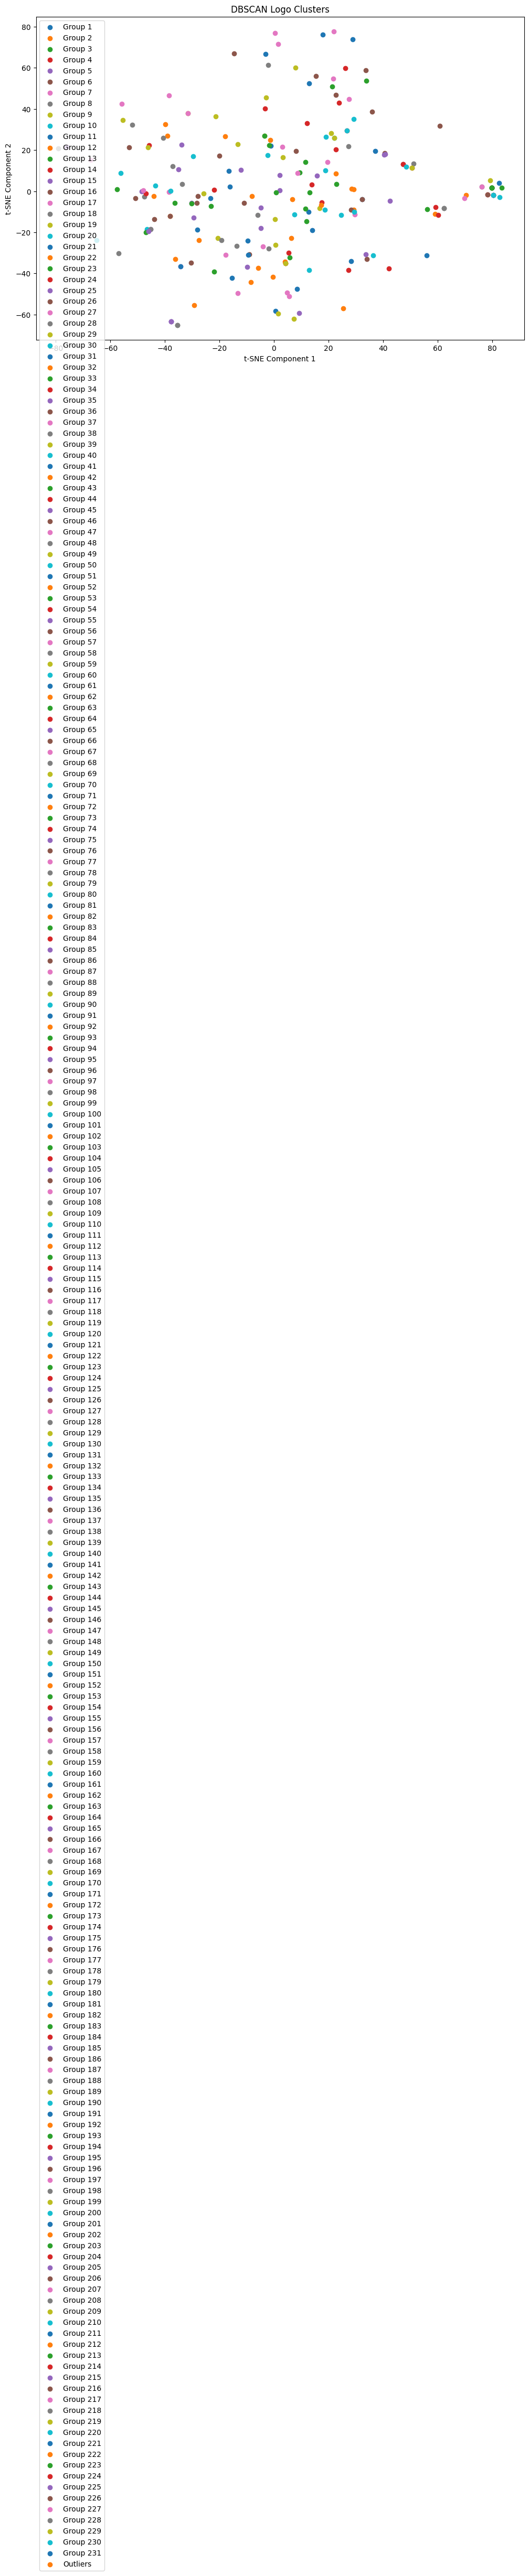


 Logo grouping completed successfully!


In [23]:
if __name__ == "__main__":
    # Load Dataset
    db_path = "processed_logos.db"
    dataset = LogoDataset(db_path)

    # Load Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LogoSimilarityModel().to(device)

    #  Extract Embeddings
    embeddings, site_names = extract_all_embeddings(model, dataset)

    #  Perform DBSCAN Clustering (Auto Cluster Detection)
    cluster_groups = cluster_logos_dbscan(embeddings, site_names, eps=0.07, min_samples=2)

    #  Print the Logo Groups
    for cluster_id, logos in cluster_groups.items():
        if cluster_id == -1:
            print("\n Outliers (logos that don't belong to any cluster):")
        else:
            print(f"\n Group {cluster_id}:")

        for logo in logos:
            print(f" - {logo}")

    # Visualize Clusters
    visualize_clusters(embeddings, cluster_groups)

    print("\n Logo grouping completed successfully!")

In [10]:
def display_group_logos(group_id, cluster_groups, db_path, num_cols=5):
    """
    Displays all logos from a given cluster group.

    Parameters:
    - group_id (int): The ID of the cluster to display.
    - cluster_groups (dict): Dictionary containing grouped logos.
    - db_path (str): Path to the SQLite database where images are stored.
    - num_cols (int): Number of columns in the grid layout.

    Returns:
    - Displays the images in a grid format.
    """

    if group_id not in cluster_groups:
        print(f" Group {group_id} does not exist.")
        return

    logos = cluster_groups[group_id]
    num_images = len(logos)
    num_rows = (num_images // num_cols) + (1 if num_images % num_cols > 0 else 0)

    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Create a figure for displaying the images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.ravel()

    for i, logo_name in enumerate(logos):
        cursor.execute("SELECT processed_image FROM logos WHERE site=?", (logo_name,))
        img_blob = cursor.fetchone()

        if img_blob:
            img_array = np.frombuffer(img_blob[0], np.uint8)
            img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            axes[i].imshow(img)
            axes[i].set_title(logo_name, fontsize=8)
            axes[i].axis("off")
        else:
            print(f" Image not found for {logo_name}")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

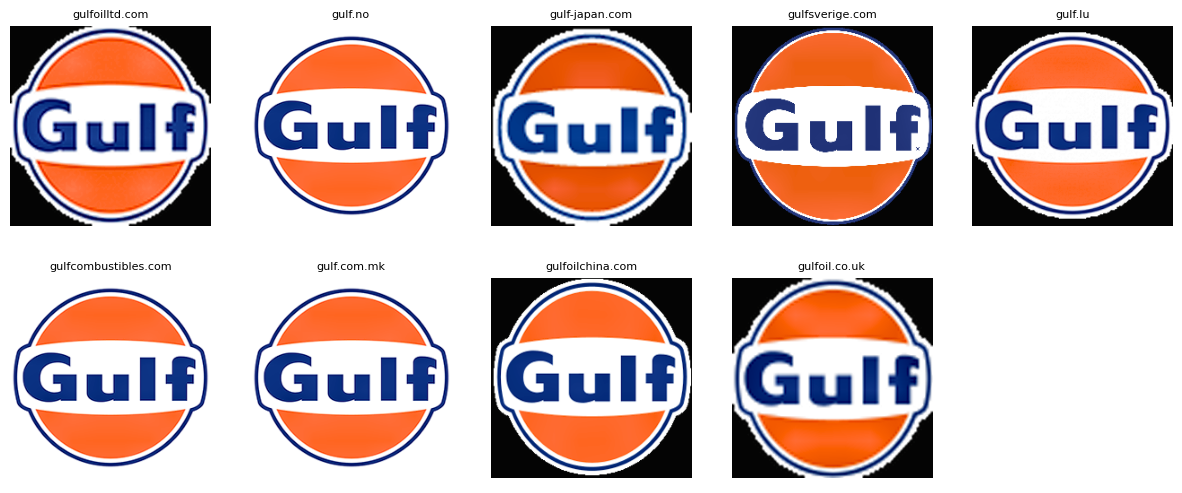

In [25]:
group_to_display = 181 # Change this number to see another group
display_group_logos(group_to_display, cluster_groups, db_path="processed_logos.db")
